In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
allow_train = True
load_pre_train_model = True
freeze_encoder = False
EPOCHS = 60
BATCH_SIZE = 64
shrink_size = None

p = 0.1 # probability for augmentation
lr = 0.001
weight_deacay = 1e-4
T_max = 10
eta_min = 0.0

# weights for alpha is inverse frequency
alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(p)
test_transforms = helper_functions.get_augmentation_test_transforms(p)
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
# load all dataloaders

train_val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    shrink_size=shrink_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


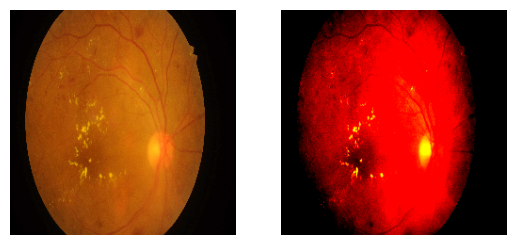

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


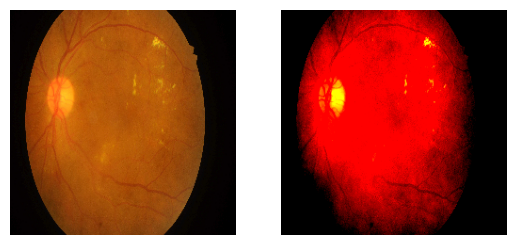

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


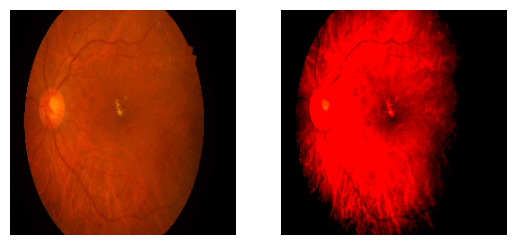

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=test_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(3):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = ThreeHeadCNN(device=device).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

# Freeze the final head
for param in model.final_head.parameters():
    param.requires_grad = False

if load_pre_train_model:
    model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

    # As the paper has stated, we reinitialize the heads weights
    model.classification_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 5) # 5 output nodes for classification
                                )
    model.regression_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 1) # 5 output nodes for classification
                                )
    model.ordinal_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 5) # 5 output nodes for classification
                                )

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 384, 384), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 384, 384]    [32, 5]              --                   Partial
├─Sequential (encoder)                                       [32, 3, 384, 384]    [32, 1792, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 48, 192, 192]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 48, 192, 192]   1,296                True
│    │    └─BatchNorm2d (1)                                  [32, 48, 192, 192]   [32, 48, 192, 192]   96                   True
│    │    └─SiLU (2)                                         [32, 48, 192, 192]   [32, 48, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 48, 192, 192]   [32, 24, 

Custom Focal Loss function

In [10]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha, gamma, headType=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha.to(device)
        self.gamma = gamma
        self.headType = headType
    def forward(self, inputs, targets):
        
        if self.headType == 'classification':
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
            # apply class weights
            # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
            weights = self.alpha.gather(0, targets)

        if self.headType == 'ordinal':
            ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            # apply class weights
            # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
            weights = self.alpha

        pt = torch.exp(-ce_loss)
        loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
        return loss.mean()

In [11]:
# Define loss and optimizer

# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)

# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
loss_fn_classification = FocalLoss(headType='classification', alpha=alpha, gamma=gamma).to(device)

# loss_fn_regression = nn.L1Loss(reduction='none').to(device)
loss_fn_regression = nn.MSELoss().to(device)

# loss_fn_ordinal = nn.BCEWithLogitsLoss().to(device)
# loss_fn_ordinal = nn.BCEWithLogitsLoss(weight=weights).to(device)
loss_fn_ordinal = FocalLoss(headType='ordinal', alpha=alpha, gamma=gamma).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

  0%|          | 0/60 [00:00<?, ?it/s]c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  2%|▏         | 1/60 [00:33<32:50, 33.40s/it]

Epoch: 0
loss_classification_train: 0.7865 | loss_regression_train: 1.7625 | loss_ordinal_train: 0.3584
loss_classification_validation: 0.6358 | loss_regression_validation: 0.5143 | loss_ordinal_validation: 0.1997
acc_classification_validation: 0.5734 | acc_regression_validation: 0.6362 | acc_ordinal_validation: 0.5350



 10%|█         | 6/60 [01:38<12:46, 14.20s/it]

Epoch: 5
loss_classification_train: 0.3629 | loss_regression_train: 0.3471 | loss_ordinal_train: 0.1033
loss_classification_validation: 0.4044 | loss_regression_validation: 0.3404 | loss_ordinal_validation: 0.1017
acc_classification_validation: 0.7356 | acc_regression_validation: 0.7298 | acc_ordinal_validation: 0.7675



 18%|█▊        | 11/60 [02:43<10:44, 13.16s/it]

Epoch: 10
loss_classification_train: 0.2641 | loss_regression_train: 0.2605 | loss_ordinal_train: 0.0747
loss_classification_validation: 0.5051 | loss_regression_validation: 0.3733 | loss_ordinal_validation: 0.1238
acc_classification_validation: 0.6866 | acc_regression_validation: 0.7382 | acc_ordinal_validation: 0.7492



 27%|██▋       | 16/60 [03:48<09:33, 13.04s/it]

Epoch: 15
loss_classification_train: 0.1726 | loss_regression_train: 0.1912 | loss_ordinal_train: 0.0504
loss_classification_validation: 0.5127 | loss_regression_validation: 0.3381 | loss_ordinal_validation: 0.1337
acc_classification_validation: 0.7712 | acc_regression_validation: 0.7518 | acc_ordinal_validation: 0.7774



 35%|███▌      | 21/60 [04:53<08:26, 13.00s/it]

Epoch: 20
loss_classification_train: 0.1543 | loss_regression_train: 0.2018 | loss_ordinal_train: 0.0481
loss_classification_validation: 0.6250 | loss_regression_validation: 0.3292 | loss_ordinal_validation: 0.1689
acc_classification_validation: 0.7638 | acc_regression_validation: 0.7602 | acc_ordinal_validation: 0.7810



 43%|████▎     | 26/60 [05:58<07:20, 12.96s/it]

Epoch: 25
loss_classification_train: 0.1172 | loss_regression_train: 0.1529 | loss_ordinal_train: 0.0366
loss_classification_validation: 0.6735 | loss_regression_validation: 0.3593 | loss_ordinal_validation: 0.1683
acc_classification_validation: 0.7727 | acc_regression_validation: 0.7461 | acc_ordinal_validation: 0.7753



 52%|█████▏    | 31/60 [07:03<06:16, 12.97s/it]

Epoch: 30
loss_classification_train: 0.1183 | loss_regression_train: 0.1682 | loss_ordinal_train: 0.0365
loss_classification_validation: 0.6628 | loss_regression_validation: 0.3594 | loss_ordinal_validation: 0.1619
acc_classification_validation: 0.7560 | acc_regression_validation: 0.7445 | acc_ordinal_validation: 0.7748



 60%|██████    | 36/60 [08:07<05:09, 12.91s/it]

Epoch: 35
loss_classification_train: 0.1028 | loss_regression_train: 0.1457 | loss_ordinal_train: 0.0295
loss_classification_validation: 0.5830 | loss_regression_validation: 0.3539 | loss_ordinal_validation: 0.1606
acc_classification_validation: 0.7346 | acc_regression_validation: 0.7460 | acc_ordinal_validation: 0.7778



 68%|██████▊   | 41/60 [09:11<04:04, 12.86s/it]

Epoch: 40
loss_classification_train: 0.1049 | loss_regression_train: 0.1563 | loss_ordinal_train: 0.0326
loss_classification_validation: 0.6049 | loss_regression_validation: 0.3813 | loss_ordinal_validation: 0.1567
acc_classification_validation: 0.7576 | acc_regression_validation: 0.7216 | acc_ordinal_validation: 0.7680



 77%|███████▋  | 46/60 [10:16<02:59, 12.84s/it]

Epoch: 45
loss_classification_train: 0.0925 | loss_regression_train: 0.1346 | loss_ordinal_train: 0.0302
loss_classification_validation: 0.8664 | loss_regression_validation: 0.3647 | loss_ordinal_validation: 0.2322
acc_classification_validation: 0.7456 | acc_regression_validation: 0.7540 | acc_ordinal_validation: 0.7608



 85%|████████▌ | 51/60 [11:20<01:55, 12.88s/it]

Epoch: 50
loss_classification_train: 0.0882 | loss_regression_train: 0.1176 | loss_ordinal_train: 0.0248
loss_classification_validation: 0.8412 | loss_regression_validation: 0.3509 | loss_ordinal_validation: 0.2010
acc_classification_validation: 0.7571 | acc_regression_validation: 0.7498 | acc_ordinal_validation: 0.7701



 93%|█████████▎| 56/60 [12:25<00:51, 12.96s/it]

Epoch: 55
loss_classification_train: 0.0764 | loss_regression_train: 0.1024 | loss_ordinal_train: 0.0230
loss_classification_validation: 0.8602 | loss_regression_validation: 0.3615 | loss_ordinal_validation: 0.2362
acc_classification_validation: 0.7039 | acc_regression_validation: 0.7273 | acc_ordinal_validation: 0.7445



100%|██████████| 60/60 [13:16<00:00, 13.28s/it]


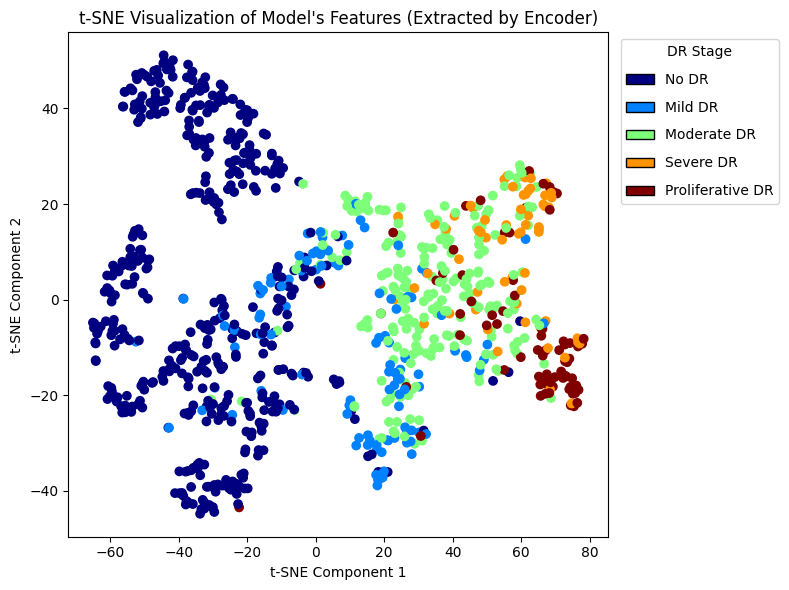

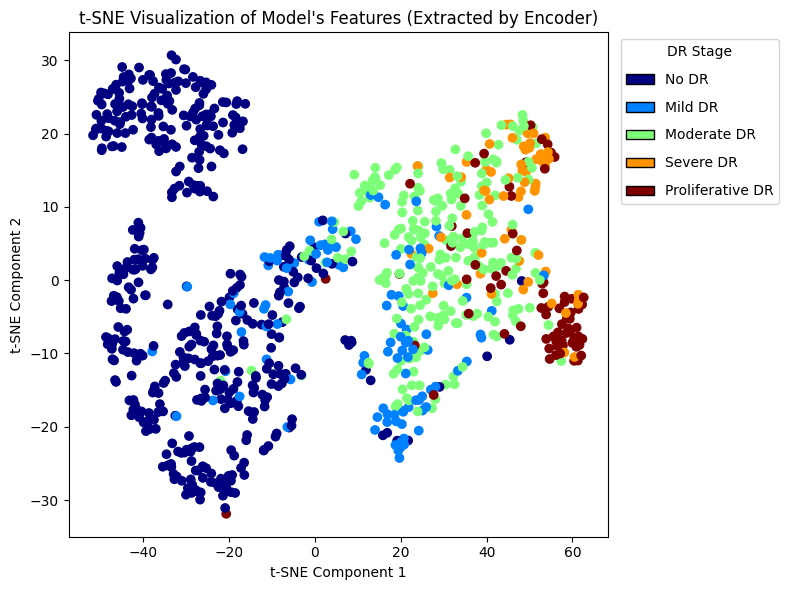

  2%|▏         | 1/60 [00:32<32:07, 32.67s/it]

Epoch: 0
loss_classification_train: 0.2073 | loss_regression_train: 0.1864 | loss_ordinal_train: 0.0591
loss_classification_validation: 0.0853 | loss_regression_validation: 0.1300 | loss_ordinal_validation: 0.0271
acc_classification_validation: 0.9264 | acc_regression_validation: 0.8785 | acc_ordinal_validation: 0.9483



 10%|█         | 6/60 [01:36<12:31, 13.92s/it]

Epoch: 5
loss_classification_train: 0.1063 | loss_regression_train: 0.1325 | loss_ordinal_train: 0.0383
loss_classification_validation: 0.0965 | loss_regression_validation: 0.0839 | loss_ordinal_validation: 0.0287
acc_classification_validation: 0.9317 | acc_regression_validation: 0.9119 | acc_ordinal_validation: 0.9406



 18%|█▊        | 11/60 [02:40<10:40, 13.07s/it]

Epoch: 10
loss_classification_train: 0.1112 | loss_regression_train: 0.1346 | loss_ordinal_train: 0.0341
loss_classification_validation: 0.1900 | loss_regression_validation: 0.1933 | loss_ordinal_validation: 0.0573
acc_classification_validation: 0.8910 | acc_regression_validation: 0.8383 | acc_ordinal_validation: 0.8858



 27%|██▋       | 16/60 [03:44<09:24, 12.83s/it]

Epoch: 15
loss_classification_train: 0.0879 | loss_regression_train: 0.1358 | loss_ordinal_train: 0.0263
loss_classification_validation: 0.2616 | loss_regression_validation: 0.2022 | loss_ordinal_validation: 0.0790
acc_classification_validation: 0.8676 | acc_regression_validation: 0.8431 | acc_ordinal_validation: 0.8655



 35%|███▌      | 21/60 [04:48<08:16, 12.72s/it]

Epoch: 20
loss_classification_train: 0.0714 | loss_regression_train: 0.1008 | loss_ordinal_train: 0.0232
loss_classification_validation: 0.2177 | loss_regression_validation: 0.1462 | loss_ordinal_validation: 0.0572
acc_classification_validation: 0.8832 | acc_regression_validation: 0.8572 | acc_ordinal_validation: 0.8952



 43%|████▎     | 26/60 [05:51<07:10, 12.66s/it]

Epoch: 25
loss_classification_train: 0.0680 | loss_regression_train: 0.0931 | loss_ordinal_train: 0.0222
loss_classification_validation: 0.2916 | loss_regression_validation: 0.1819 | loss_ordinal_validation: 0.0787
acc_classification_validation: 0.8701 | acc_regression_validation: 0.8450 | acc_ordinal_validation: 0.8716



 52%|█████▏    | 31/60 [06:55<06:09, 12.73s/it]

Epoch: 30
loss_classification_train: 0.0627 | loss_regression_train: 0.1118 | loss_ordinal_train: 0.0195
loss_classification_validation: 0.2870 | loss_regression_validation: 0.1987 | loss_ordinal_validation: 0.0933
acc_classification_validation: 0.8087 | acc_regression_validation: 0.8107 | acc_ordinal_validation: 0.8410



 60%|██████    | 36/60 [07:58<05:04, 12.69s/it]

Epoch: 35
loss_classification_train: 0.0694 | loss_regression_train: 0.0958 | loss_ordinal_train: 0.0210
loss_classification_validation: 0.3377 | loss_regression_validation: 0.2382 | loss_ordinal_validation: 0.0993
acc_classification_validation: 0.8369 | acc_regression_validation: 0.8253 | acc_ordinal_validation: 0.8582



 68%|██████▊   | 41/60 [09:02<04:00, 12.68s/it]

Epoch: 40
loss_classification_train: 0.0705 | loss_regression_train: 0.1020 | loss_ordinal_train: 0.0223
loss_classification_validation: 0.3085 | loss_regression_validation: 0.2335 | loss_ordinal_validation: 0.0839
acc_classification_validation: 0.8384 | acc_regression_validation: 0.8075 | acc_ordinal_validation: 0.8608



 77%|███████▋  | 46/60 [10:05<02:57, 12.70s/it]

Epoch: 45
loss_classification_train: 0.0696 | loss_regression_train: 0.1032 | loss_ordinal_train: 0.0223
loss_classification_validation: 0.4008 | loss_regression_validation: 0.2560 | loss_ordinal_validation: 0.1187
acc_classification_validation: 0.8226 | acc_regression_validation: 0.8325 | acc_ordinal_validation: 0.8445



 85%|████████▌ | 51/60 [11:09<01:54, 12.73s/it]

Epoch: 50
loss_classification_train: 0.0656 | loss_regression_train: 0.0998 | loss_ordinal_train: 0.0202
loss_classification_validation: 0.4465 | loss_regression_validation: 0.1979 | loss_ordinal_validation: 0.1081
acc_classification_validation: 0.8018 | acc_regression_validation: 0.8217 | acc_ordinal_validation: 0.8420



 93%|█████████▎| 56/60 [12:12<00:50, 12.70s/it]

Epoch: 55
loss_classification_train: 0.0590 | loss_regression_train: 0.0883 | loss_ordinal_train: 0.0176
loss_classification_validation: 0.4980 | loss_regression_validation: 0.2353 | loss_ordinal_validation: 0.1379
acc_classification_validation: 0.8025 | acc_regression_validation: 0.8009 | acc_ordinal_validation: 0.8182



100%|██████████| 60/60 [13:04<00:00, 13.07s/it]


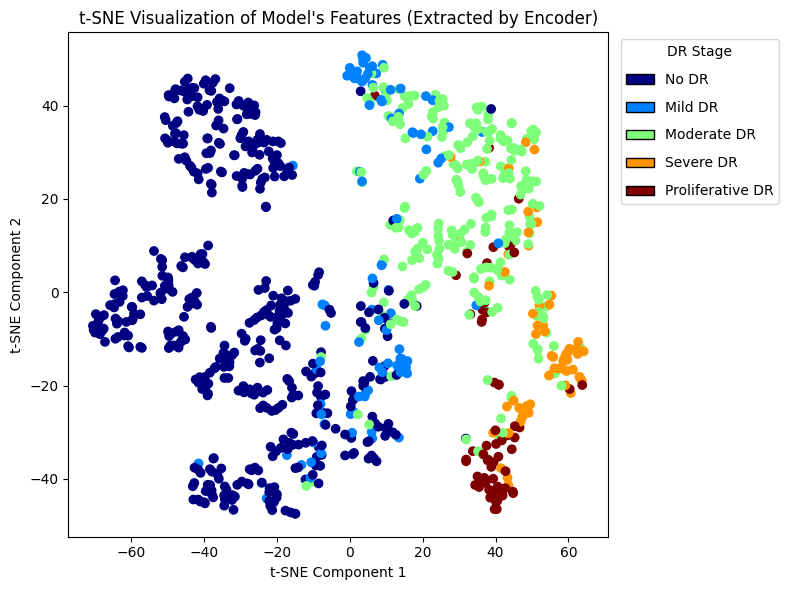

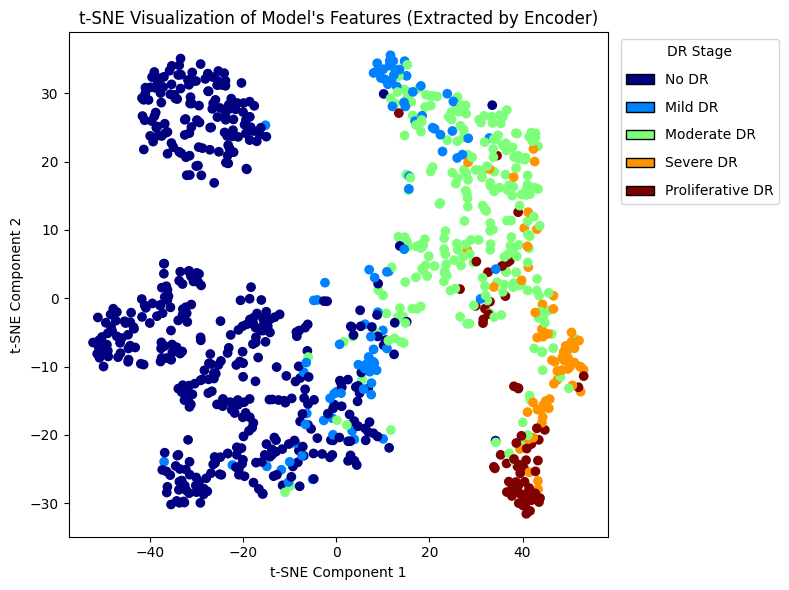

  2%|▏         | 1/60 [00:33<33:23, 33.97s/it]

Epoch: 0
loss_classification_train: 0.1864 | loss_regression_train: 0.1870 | loss_ordinal_train: 0.0525
loss_classification_validation: 0.0993 | loss_regression_validation: 0.0718 | loss_ordinal_validation: 0.0377
acc_classification_validation: 0.8936 | acc_regression_validation: 0.9317 | acc_ordinal_validation: 0.9395



 10%|█         | 6/60 [01:38<12:39, 14.06s/it]

Epoch: 5
loss_classification_train: 0.0925 | loss_regression_train: 0.1299 | loss_ordinal_train: 0.0276
loss_classification_validation: 0.0682 | loss_regression_validation: 0.0785 | loss_ordinal_validation: 0.0214
acc_classification_validation: 0.9427 | acc_regression_validation: 0.9369 | acc_ordinal_validation: 0.9458



 18%|█▊        | 11/60 [02:43<10:43, 13.13s/it]

Epoch: 10
loss_classification_train: 0.0712 | loss_regression_train: 0.0999 | loss_ordinal_train: 0.0221
loss_classification_validation: 0.1231 | loss_regression_validation: 0.0900 | loss_ordinal_validation: 0.0335
acc_classification_validation: 0.9192 | acc_regression_validation: 0.9172 | acc_ordinal_validation: 0.9297



 27%|██▋       | 16/60 [03:47<09:29, 12.93s/it]

Epoch: 15
loss_classification_train: 0.0752 | loss_regression_train: 0.0902 | loss_ordinal_train: 0.0230
loss_classification_validation: 0.1478 | loss_regression_validation: 0.1054 | loss_ordinal_validation: 0.0438
acc_classification_validation: 0.9239 | acc_regression_validation: 0.9192 | acc_ordinal_validation: 0.9281



 35%|███▌      | 21/60 [04:51<08:21, 12.85s/it]

Epoch: 20
loss_classification_train: 0.0935 | loss_regression_train: 0.1154 | loss_ordinal_train: 0.0262
loss_classification_validation: 0.1324 | loss_regression_validation: 0.1126 | loss_ordinal_validation: 0.0371
acc_classification_validation: 0.9109 | acc_regression_validation: 0.9104 | acc_ordinal_validation: 0.9239



 43%|████▎     | 26/60 [05:56<07:18, 12.90s/it]

Epoch: 25
loss_classification_train: 0.0576 | loss_regression_train: 0.0874 | loss_ordinal_train: 0.0189
loss_classification_validation: 0.1986 | loss_regression_validation: 0.1277 | loss_ordinal_validation: 0.0502
acc_classification_validation: 0.9030 | acc_regression_validation: 0.8900 | acc_ordinal_validation: 0.9036



 52%|█████▏    | 31/60 [07:01<06:16, 12.97s/it]

Epoch: 30
loss_classification_train: 0.0660 | loss_regression_train: 0.0952 | loss_ordinal_train: 0.0197
loss_classification_validation: 0.2331 | loss_regression_validation: 0.1733 | loss_ordinal_validation: 0.0658
acc_classification_validation: 0.8847 | acc_regression_validation: 0.8728 | acc_ordinal_validation: 0.8858



 60%|██████    | 36/60 [08:05<05:08, 12.87s/it]

Epoch: 35
loss_classification_train: 0.0685 | loss_regression_train: 0.0922 | loss_ordinal_train: 0.0198
loss_classification_validation: 0.2328 | loss_regression_validation: 0.1416 | loss_ordinal_validation: 0.0605
acc_classification_validation: 0.8780 | acc_regression_validation: 0.8727 | acc_ordinal_validation: 0.8921



 68%|██████▊   | 41/60 [09:10<04:05, 12.93s/it]

Epoch: 40
loss_classification_train: 0.0710 | loss_regression_train: 0.0925 | loss_ordinal_train: 0.0210
loss_classification_validation: 0.2773 | loss_regression_validation: 0.1764 | loss_ordinal_validation: 0.0746
acc_classification_validation: 0.8738 | acc_regression_validation: 0.8410 | acc_ordinal_validation: 0.8848



 77%|███████▋  | 46/60 [10:14<03:00, 12.87s/it]

Epoch: 45
loss_classification_train: 0.0634 | loss_regression_train: 0.0777 | loss_ordinal_train: 0.0195
loss_classification_validation: 0.2625 | loss_regression_validation: 0.1788 | loss_ordinal_validation: 0.0718
acc_classification_validation: 0.8702 | acc_regression_validation: 0.8608 | acc_ordinal_validation: 0.8676



 85%|████████▌ | 51/60 [11:18<01:55, 12.85s/it]

Epoch: 50
loss_classification_train: 0.0511 | loss_regression_train: 0.0733 | loss_ordinal_train: 0.0167
loss_classification_validation: 0.3541 | loss_regression_validation: 0.1852 | loss_ordinal_validation: 0.0829
acc_classification_validation: 0.8431 | acc_regression_validation: 0.8369 | acc_ordinal_validation: 0.8562



 93%|█████████▎| 56/60 [12:22<00:51, 12.84s/it]

Epoch: 55
loss_classification_train: 0.0735 | loss_regression_train: 0.0904 | loss_ordinal_train: 0.0196
loss_classification_validation: 0.3423 | loss_regression_validation: 0.1999 | loss_ordinal_validation: 0.1035
acc_classification_validation: 0.8305 | acc_regression_validation: 0.8446 | acc_ordinal_validation: 0.8493



100%|██████████| 60/60 [13:14<00:00, 13.24s/it]


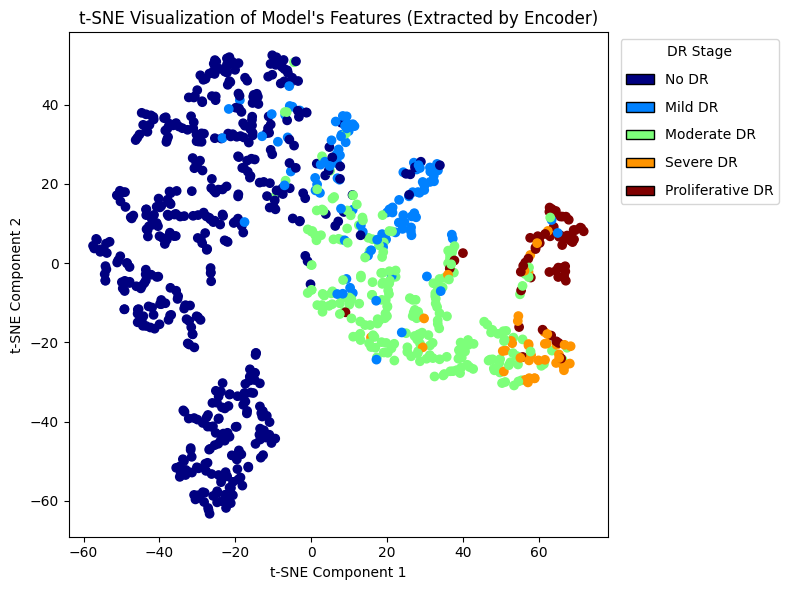

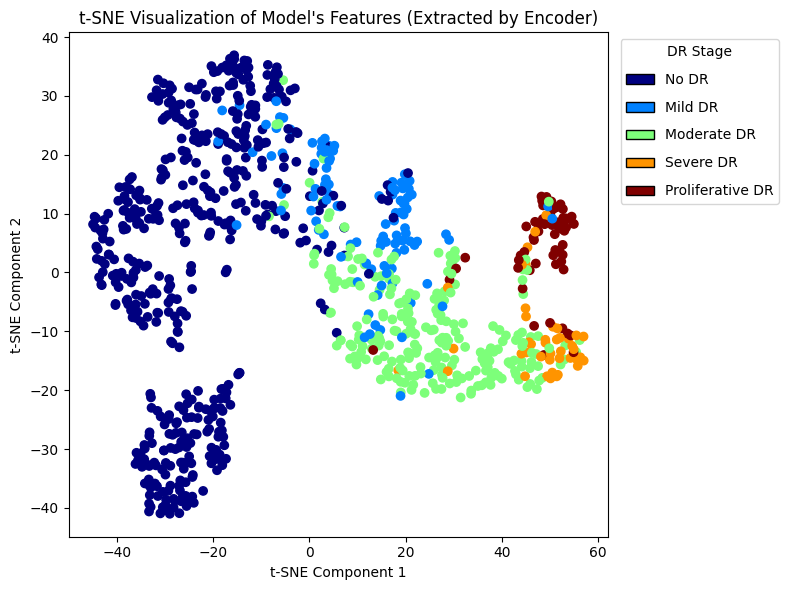

  2%|▏         | 1/60 [00:32<32:20, 32.88s/it]

Epoch: 0
loss_classification_train: 0.1295 | loss_regression_train: 0.1257 | loss_ordinal_train: 0.0382
loss_classification_validation: 0.0458 | loss_regression_validation: 0.0411 | loss_ordinal_validation: 0.0144
acc_classification_validation: 0.9567 | acc_regression_validation: 0.9609 | acc_ordinal_validation: 0.9682



 10%|█         | 6/60 [01:37<12:44, 14.15s/it]

Epoch: 5
loss_classification_train: 0.0789 | loss_regression_train: 0.0993 | loss_ordinal_train: 0.0261
loss_classification_validation: 0.0681 | loss_regression_validation: 0.0579 | loss_ordinal_validation: 0.0207
acc_classification_validation: 0.9525 | acc_regression_validation: 0.9467 | acc_ordinal_validation: 0.9536



 18%|█▊        | 11/60 [02:42<10:44, 13.15s/it]

Epoch: 10
loss_classification_train: 0.0670 | loss_regression_train: 0.0943 | loss_ordinal_train: 0.0204
loss_classification_validation: 0.0951 | loss_regression_validation: 0.0789 | loss_ordinal_validation: 0.0273
acc_classification_validation: 0.9201 | acc_regression_validation: 0.9305 | acc_ordinal_validation: 0.9347



 27%|██▋       | 16/60 [03:47<09:30, 12.95s/it]

Epoch: 15
loss_classification_train: 0.0810 | loss_regression_train: 0.1045 | loss_ordinal_train: 0.0254
loss_classification_validation: 0.1179 | loss_regression_validation: 0.0915 | loss_ordinal_validation: 0.0285
acc_classification_validation: 0.9216 | acc_regression_validation: 0.9113 | acc_ordinal_validation: 0.9222



 35%|███▌      | 21/60 [04:52<08:26, 12.98s/it]

Epoch: 20
loss_classification_train: 0.0667 | loss_regression_train: 0.1001 | loss_ordinal_train: 0.0213
loss_classification_validation: 0.1693 | loss_regression_validation: 0.1051 | loss_ordinal_validation: 0.0451
acc_classification_validation: 0.9234 | acc_regression_validation: 0.9165 | acc_ordinal_validation: 0.9145



 43%|████▎     | 26/60 [05:56<07:18, 12.90s/it]

Epoch: 25
loss_classification_train: 0.0583 | loss_regression_train: 0.0858 | loss_ordinal_train: 0.0205
loss_classification_validation: 0.1740 | loss_regression_validation: 0.0760 | loss_ordinal_validation: 0.0398
acc_classification_validation: 0.9307 | acc_regression_validation: 0.9275 | acc_ordinal_validation: 0.9286



 52%|█████▏    | 31/60 [07:01<06:15, 12.94s/it]

Epoch: 30
loss_classification_train: 0.0653 | loss_regression_train: 0.0786 | loss_ordinal_train: 0.0203
loss_classification_validation: 0.3021 | loss_regression_validation: 0.1353 | loss_ordinal_validation: 0.0717
acc_classification_validation: 0.8147 | acc_regression_validation: 0.8621 | acc_ordinal_validation: 0.8532



 60%|██████    | 36/60 [08:06<05:10, 12.93s/it]

Epoch: 35
loss_classification_train: 0.0659 | loss_regression_train: 0.0967 | loss_ordinal_train: 0.0218
loss_classification_validation: 0.1578 | loss_regression_validation: 0.1117 | loss_ordinal_validation: 0.0476
acc_classification_validation: 0.9062 | acc_regression_validation: 0.8899 | acc_ordinal_validation: 0.9061



 68%|██████▊   | 41/60 [09:10<04:06, 12.98s/it]

Epoch: 40
loss_classification_train: 0.0522 | loss_regression_train: 0.0834 | loss_ordinal_train: 0.0166
loss_classification_validation: 0.2136 | loss_regression_validation: 0.1125 | loss_ordinal_validation: 0.0526
acc_classification_validation: 0.8815 | acc_regression_validation: 0.8882 | acc_ordinal_validation: 0.9038



 77%|███████▋  | 46/60 [10:15<03:01, 12.98s/it]

Epoch: 45
loss_classification_train: 0.0715 | loss_regression_train: 0.0888 | loss_ordinal_train: 0.0240
loss_classification_validation: 0.2453 | loss_regression_validation: 0.1501 | loss_ordinal_validation: 0.0665
acc_classification_validation: 0.8839 | acc_regression_validation: 0.8688 | acc_ordinal_validation: 0.8908



 85%|████████▌ | 51/60 [11:19<01:56, 12.93s/it]

Epoch: 50
loss_classification_train: 0.0644 | loss_regression_train: 0.0780 | loss_ordinal_train: 0.0192
loss_classification_validation: 0.2042 | loss_regression_validation: 0.1615 | loss_ordinal_validation: 0.0618
acc_classification_validation: 0.8444 | acc_regression_validation: 0.8557 | acc_ordinal_validation: 0.8665



 93%|█████████▎| 56/60 [12:24<00:51, 12.85s/it]

Epoch: 55
loss_classification_train: 0.0560 | loss_regression_train: 0.0976 | loss_ordinal_train: 0.0176
loss_classification_validation: 0.2841 | loss_regression_validation: 0.1518 | loss_ordinal_validation: 0.0760
acc_classification_validation: 0.8868 | acc_regression_validation: 0.8795 | acc_ordinal_validation: 0.8857



100%|██████████| 60/60 [13:15<00:00, 13.26s/it]


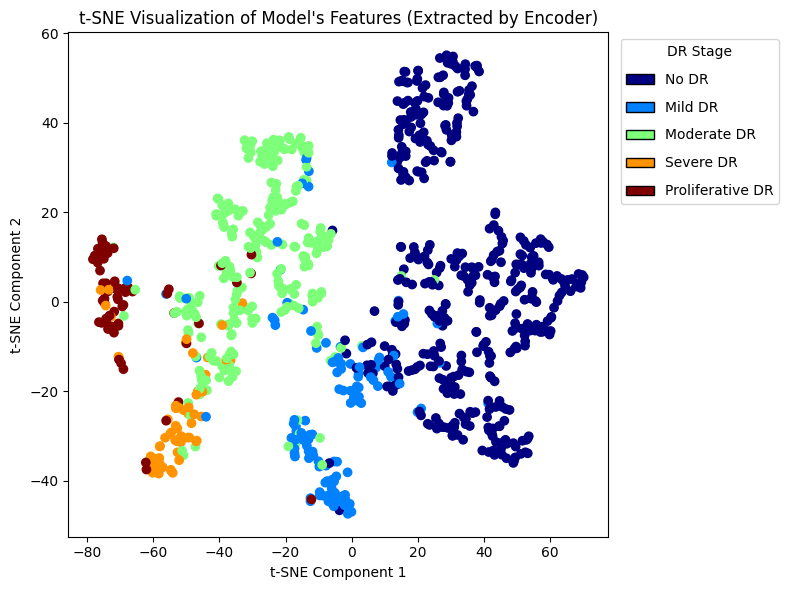

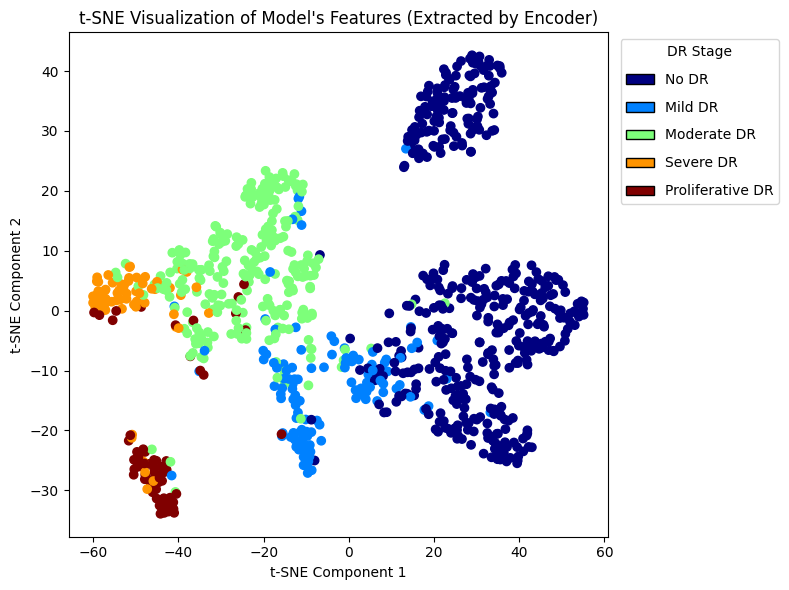

  2%|▏         | 1/60 [00:32<31:44, 32.29s/it]

Epoch: 0
loss_classification_train: 0.1170 | loss_regression_train: 0.1125 | loss_ordinal_train: 0.0364
loss_classification_validation: 0.0289 | loss_regression_validation: 0.0341 | loss_ordinal_validation: 0.0106
acc_classification_validation: 0.9634 | acc_regression_validation: 0.9707 | acc_ordinal_validation: 0.9801



 10%|█         | 6/60 [01:37<12:38, 14.04s/it]

Epoch: 5
loss_classification_train: 0.0774 | loss_regression_train: 0.0882 | loss_ordinal_train: 0.0241
loss_classification_validation: 0.0408 | loss_regression_validation: 0.0363 | loss_ordinal_validation: 0.0133
acc_classification_validation: 0.9661 | acc_regression_validation: 0.9640 | acc_ordinal_validation: 0.9744



 18%|█▊        | 11/60 [02:42<10:47, 13.22s/it]

Epoch: 10
loss_classification_train: 0.0722 | loss_regression_train: 0.0872 | loss_ordinal_train: 0.0235
loss_classification_validation: 0.0620 | loss_regression_validation: 0.0549 | loss_ordinal_validation: 0.0214
acc_classification_validation: 0.9588 | acc_regression_validation: 0.9467 | acc_ordinal_validation: 0.9588



 27%|██▋       | 16/60 [03:47<09:35, 13.09s/it]

Epoch: 15
loss_classification_train: 0.0615 | loss_regression_train: 0.0857 | loss_ordinal_train: 0.0221
loss_classification_validation: 0.0732 | loss_regression_validation: 0.0607 | loss_ordinal_validation: 0.0231
acc_classification_validation: 0.9598 | acc_regression_validation: 0.9426 | acc_ordinal_validation: 0.9514



 35%|███▌      | 21/60 [04:52<08:29, 13.06s/it]

Epoch: 20
loss_classification_train: 0.0463 | loss_regression_train: 0.0731 | loss_ordinal_train: 0.0168
loss_classification_validation: 0.0623 | loss_regression_validation: 0.0534 | loss_ordinal_validation: 0.0178
acc_classification_validation: 0.9587 | acc_regression_validation: 0.9533 | acc_ordinal_validation: 0.9544



 43%|████▎     | 26/60 [05:58<07:25, 13.10s/it]

Epoch: 25
loss_classification_train: 0.0603 | loss_regression_train: 0.0922 | loss_ordinal_train: 0.0189
loss_classification_validation: 0.1077 | loss_regression_validation: 0.0839 | loss_ordinal_validation: 0.0344
acc_classification_validation: 0.9175 | acc_regression_validation: 0.9222 | acc_ordinal_validation: 0.9362



 52%|█████▏    | 31/60 [07:03<06:18, 13.04s/it]

Epoch: 30
loss_classification_train: 0.0559 | loss_regression_train: 0.0743 | loss_ordinal_train: 0.0207
loss_classification_validation: 0.1439 | loss_regression_validation: 0.0958 | loss_ordinal_validation: 0.0533
acc_classification_validation: 0.9169 | acc_regression_validation: 0.9231 | acc_ordinal_validation: 0.9184



 60%|██████    | 36/60 [08:08<05:12, 13.03s/it]

Epoch: 35
loss_classification_train: 0.0611 | loss_regression_train: 0.0766 | loss_ordinal_train: 0.0211
loss_classification_validation: 0.1377 | loss_regression_validation: 0.1032 | loss_ordinal_validation: 0.0391
acc_classification_validation: 0.9032 | acc_regression_validation: 0.9102 | acc_ordinal_validation: 0.9195



 68%|██████▊   | 41/60 [09:14<04:09, 13.12s/it]

Epoch: 40
loss_classification_train: 0.0475 | loss_regression_train: 0.0697 | loss_ordinal_train: 0.0168
loss_classification_validation: 0.1401 | loss_regression_validation: 0.0844 | loss_ordinal_validation: 0.0428
acc_classification_validation: 0.9160 | acc_regression_validation: 0.9247 | acc_ordinal_validation: 0.9191



 77%|███████▋  | 46/60 [10:19<03:01, 12.99s/it]

Epoch: 45
loss_classification_train: 0.0649 | loss_regression_train: 0.0843 | loss_ordinal_train: 0.0203
loss_classification_validation: 0.1460 | loss_regression_validation: 0.0986 | loss_ordinal_validation: 0.0459
acc_classification_validation: 0.9161 | acc_regression_validation: 0.9192 | acc_ordinal_validation: 0.9313



 85%|████████▌ | 51/60 [11:24<01:57, 13.01s/it]

Epoch: 50
loss_classification_train: 0.0449 | loss_regression_train: 0.0638 | loss_ordinal_train: 0.0145
loss_classification_validation: 0.2692 | loss_regression_validation: 0.1203 | loss_ordinal_validation: 0.0786
acc_classification_validation: 0.8971 | acc_regression_validation: 0.8883 | acc_ordinal_validation: 0.8898



 93%|█████████▎| 56/60 [12:29<00:52, 13.07s/it]

Epoch: 55
loss_classification_train: 0.0377 | loss_regression_train: 0.0612 | loss_ordinal_train: 0.0131
loss_classification_validation: 0.1630 | loss_regression_validation: 0.1102 | loss_ordinal_validation: 0.0461
acc_classification_validation: 0.9073 | acc_regression_validation: 0.9021 | acc_ordinal_validation: 0.9135



100%|██████████| 60/60 [13:21<00:00, 13.36s/it]


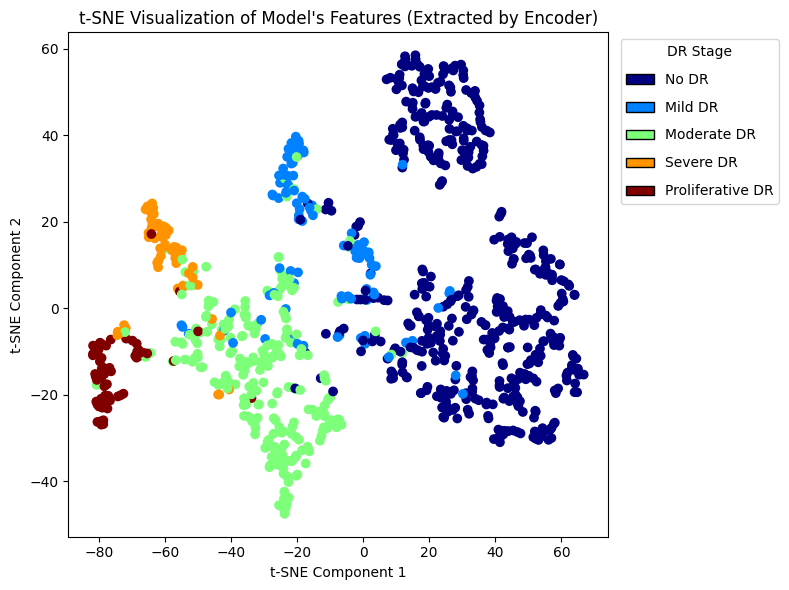

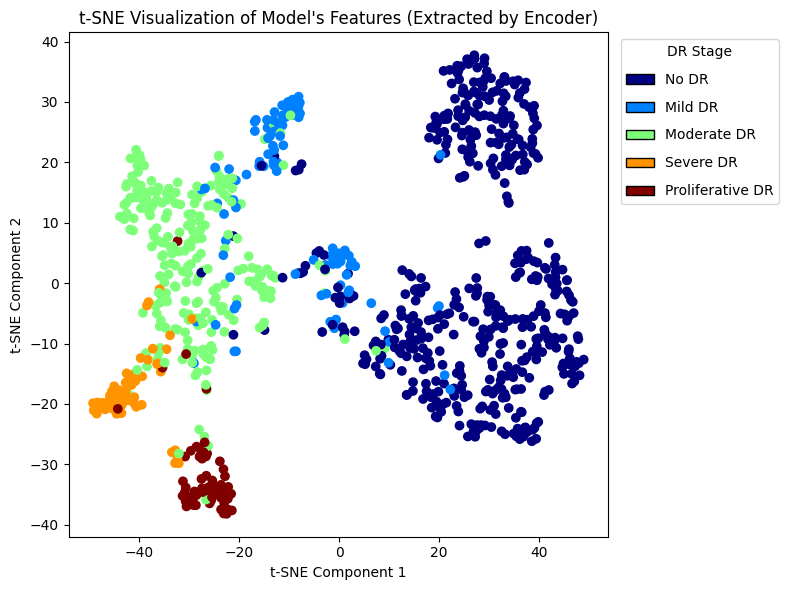

[INFO] Total training time: 3994.084 seconds
[INFO] Saving model to: models\main_train_model.pth


In [12]:
folds_train_results = {
    'loss_classification_train': [],
    'loss_regression_train': [],
    'loss_ordinal_train': []
}
folds_val_results = {
    'loss_classification_val': [],
    'loss_regression_val': [],
    'loss_ordinal_val': []
}
if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for fold in train_val_dataloader:
        train_results, val_results = engine.train(model=model,
                            train_dataloader=fold['train_dataloader'],
                            val_dataloader=fold['val_dataloader'],
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn_classification=loss_fn_classification,
                            loss_fn_regression=loss_fn_regression,
                            loss_fn_ordinal=loss_fn_ordinal,
                            epochs=EPOCHS,
                            device=device)
        
        folds_train_results['loss_classification_train'].extend(train_results['loss_classification_train'])
        folds_train_results['loss_regression_train'].extend(train_results['loss_regression_train'])
        folds_train_results['loss_ordinal_train'].extend(train_results['loss_ordinal_train'])

        folds_val_results['loss_classification_val'].extend(val_results['loss_classification_val'])
        folds_val_results['loss_regression_val'].extend(val_results['loss_regression_val'])
        folds_val_results['loss_ordinal_val'].extend(val_results['loss_ordinal_val'])

        helper_functions.plot_t_SNE(model=model,
                                dataloader=fold['val_dataloader'],
                                NUM_ITER=2000)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='main_train_model.pth')
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

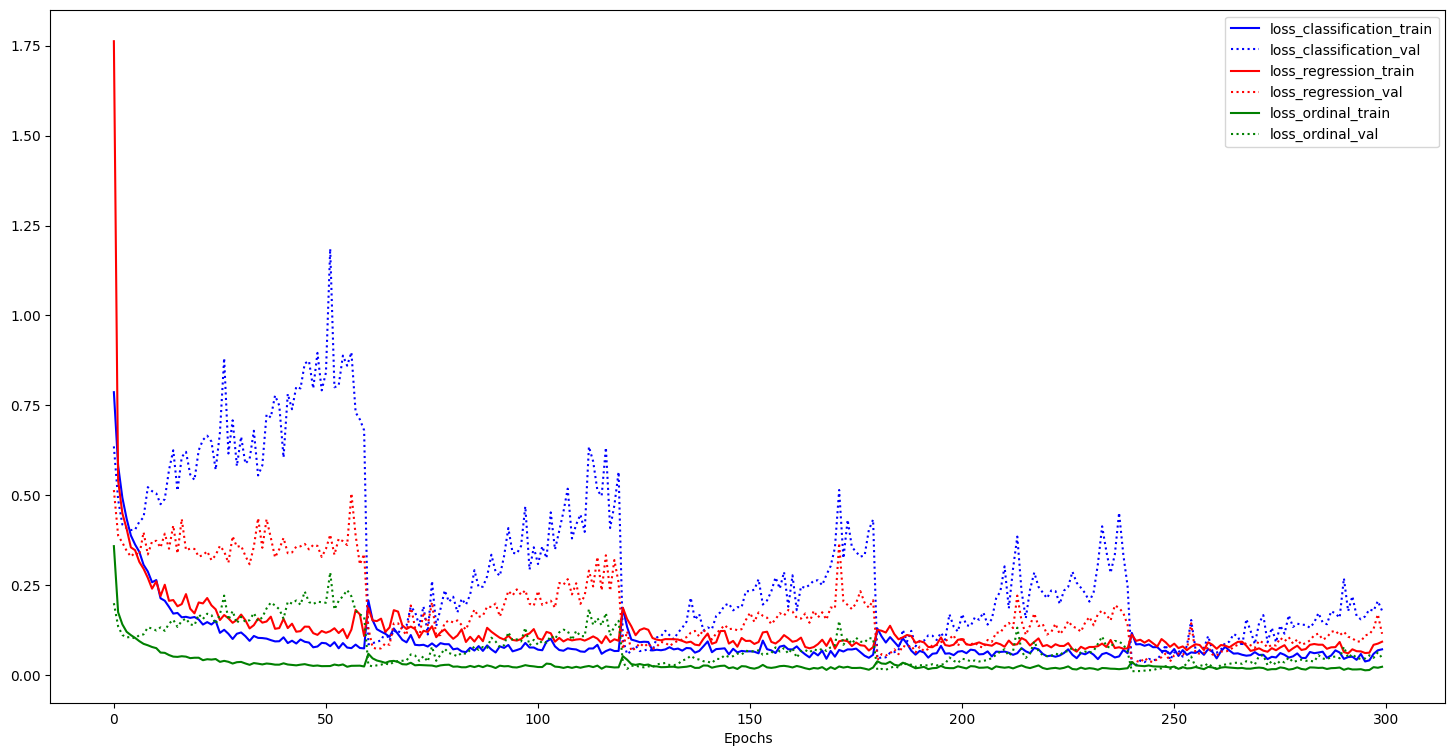

In [13]:
if allow_train:
    helper_functions.plot_loss_curves_main_train(folds_train_results, folds_val_results)

In [14]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn_classification=loss_fn_classification,
            loss_fn_regression=loss_fn_regression,
            loss_fn_ordinal=loss_fn_ordinal,
            device=device)

f1_class: tensor([0.9188, 0.4479, 0.6916, 0.4291, 0.5760]) | f1_reg: tensor([0.9169, 0.4052, 0.6987, 0.2707, 0.6065]) | f1_ord: tensor([0.9182, 0.4209, 0.7173, 0.3138, 0.6162])
test class acc: 0.7687578320802005 | test reg acc: 0.7613565162907269 | test ord acc: 0.7753367794486216
